In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import time

# 1. Dane testowe i treningowe

In [2]:
def show_data(train_data, train_label, test_data, test_label, predictions = None):
    plt.scatter(train_data, train_label, c='b', label='Training data')
    plt.scatter(test_data, test_label, c='g', label='Test data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", label='Predictions')
    plt.legend()

In [3]:
#Docelowe parametry
weight = 0.7
bias = 0.3

#Input output
start = 0
end = 1
step = 0.02
x = torch.arange(start, end, step).unsqueeze(1)
y = weight * x + bias

x[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

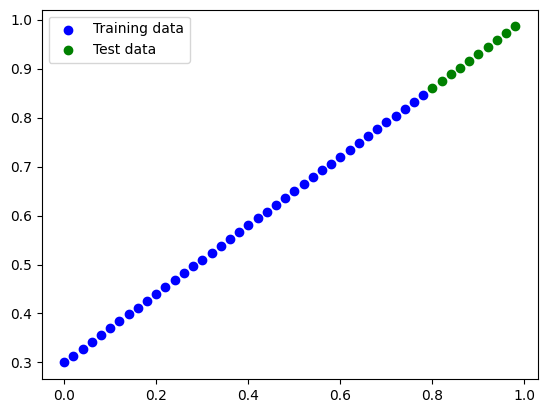

In [4]:
#Dane treningowe i walidacyjne
x_train, y_train = x[:int(0.8 * len(x))], y[:int(0.8 * len(y))]
x_test, y_test = x[int(0.8 * len(x)):], y[int(0.8 * len(x)):]
show_data(x_train, y_train, x_test, y_test)

# 2. Model NN

In [92]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                               requires_grad=True,
                                               dtype=torch.float))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.weights + self.bias   

In [93]:
model_0 = LinearRegressionModel()
#Mały model z dwoma parametrami do gradientu
list(model_0.parameters())

[Parameter containing:
 tensor([0.2737], requires_grad=True),
 Parameter containing:
 tensor([1.8281], requires_grad=True)]

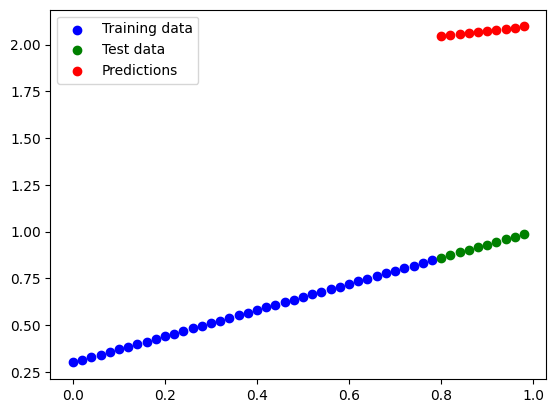

In [94]:
#Pierwsze przewidywania bez wstecznej propagacji
with torch.inference_mode():
    y_preds = model_0(x_test)
    
show_data(x_train, y_train, x_test, y_test, predictions=y_preds)

In [95]:
#Funkcja kosztu
loss_fun = nn.L1Loss() #Mean absolute error

#Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.01)

# 3. Pętla treningowa i testowa

Epoch: 0, Loss: 1.3619, Test loss: 1.1353
Epoch: 100, Loss: 0.2409, Test loss: 0.1852
Epoch: 200, Loss: 0.1442, Test loss: 0.3322
Epoch: 300, Loss: 0.1097, Test loss: 0.2557
Epoch: 400, Loss: 0.0754, Test loss: 0.1757
Epoch: 500, Loss: 0.041, Test loss: 0.095
Epoch: 600, Loss: 0.0067, Test loss: 0.0151
Epoch: 700, Loss: 0.0072, Test loss: 0.0013
Epoch: 800, Loss: 0.0072, Test loss: 0.0013
Epoch: 900, Loss: 0.0072, Test loss: 0.0013


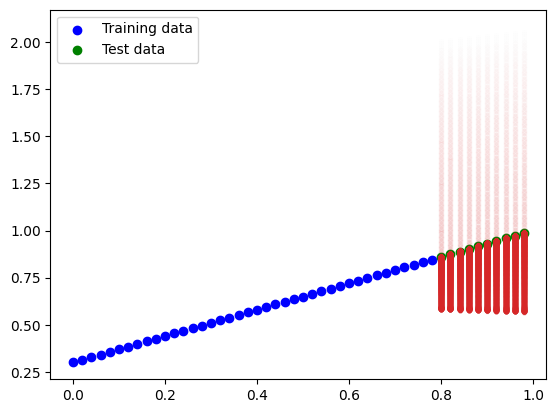

In [96]:
#Pierwotny forward pass
show_data(x_train, y_train, x_test, y_test)
alfa = 1
epochs = 1000

#Dane do śledzenia
epoch_count = []
losses = []
test_loses = []

#Pętla treningowa
for epoch in range(0, epochs):
    #Włączenie gradientu na wszystkich możliwych parametrach
    model_0.train()
    
    #____Pętla treningowa____
    #1. Forward pass
    predictions = model_0(x_train)
    
    #2. Obliczenie kosztu
    loss = loss_fun(predictions, y_train)
    
    #3. Wyzerowanie optimizera dla kolejnej pętli
    optimizer.zero_grad()
    
    #4. Backward pass
    loss.backward()
    
    #5. Optymalizacja (Gradient descent)
    optimizer.step()
    
    
    #____Pętla testowa____
    #Wyłączenie konkretnych funkcji na modelu nie potrzebnych do testowania (evaluation)
    model_0.eval()
    
    #Forward pass i rysowanie wykresu
    with torch.inference_mode():
        y_preds_new = model_0(x_test)
    test_loss = loss_fun(y_preds_new, y_test)
    
    if epoch%100 == 0:
        print(f"Epoch: {epoch}, Loss: {round(loss.item(), 4)}, Test loss: {round(test_loss.item(), 4)}")
    
    epoch_count.append(epoch)
    losses.append(loss.item())
    test_loses.append(test_loss.item())
    
    plt.scatter(x_test,  y_preds_new, c="tab:red", s=10, label='Predictions', alpha=1-alfa)
    alfa -= 1/epochs

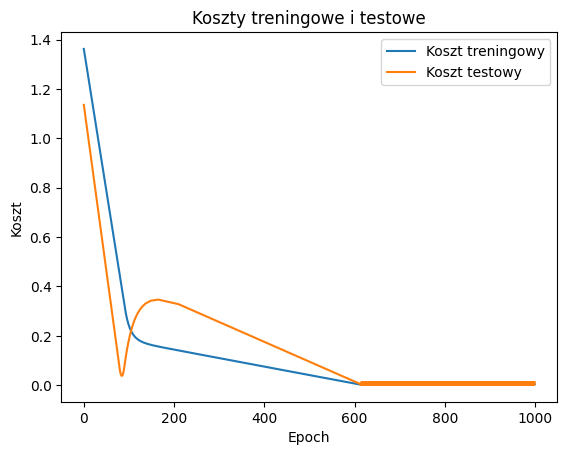

In [101]:
#Wykres kosztu
plt.plot(epoch_count, losses, label="Koszt treningowy")
plt.plot(epoch_count, test_loses, label="Koszt testowy")
plt.title("Koszty treningowe i testowe")
plt.xlabel("Epoch")
plt.ylabel("Koszt")
plt.legend()

# 4. Zapisywanie i wczytywanie modelu

In [103]:
from pathlib import Path
#___Zapisywanie do pliku___
#Utworzenie folderu modeli
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#Zapisanie nazwy modelu
MODEL_NAME = '01_LinearRegression.pt'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Zapisanie modelu pod podaną nazwą
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

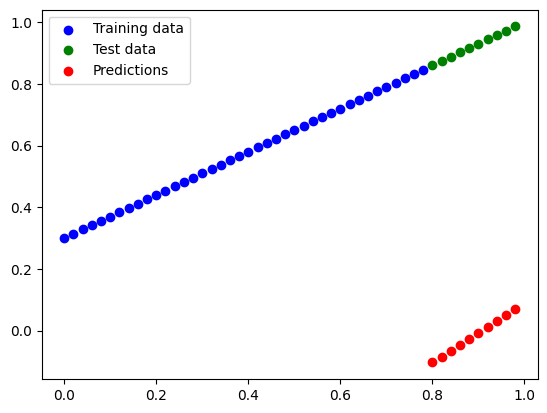

In [104]:
#___Ładowanie z pliku___
Model_test_load = LinearRegressionModel()

#Before loading
with torch.inference_mode():
    y_preds_load = Model_test_load(x_test)
    
show_data(x_train, y_train, x_test, y_test, predictions=y_preds_load)

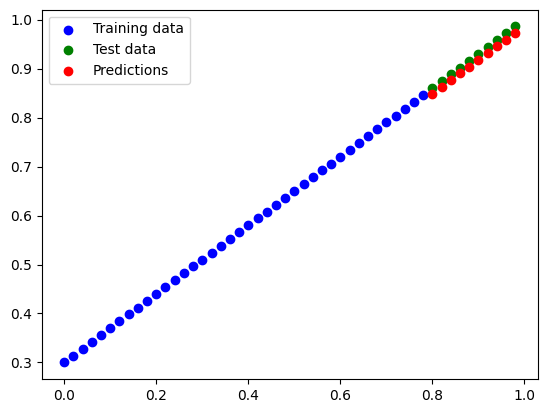

In [105]:
Model_test_load.load_state_dict(torch.load(MODEL_SAVE_PATH))

#After Loading
with torch.inference_mode():
    y_preds_load = Model_test_load(x_test)
    
show_data(x_train, y_train, x_test, y_test, predictions=y_preds_load)